# PART 2 MODELING PREP - FEATURE ENGINEERING

## 1. Setup and Imports

In [194]:
# !pip install scikit-learn imbalanced-learn pandas numpy matplotlib plotnine joblib seaborn category-encoders xgboost lightgbm shap

In [195]:
# Imports
import os
import json
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

from sklearn.ensemble import RandomForestClassifier
# Optional (XGBoost + SHAP)
import xgboost as xgb
import shap

import matplotlib.pyplot as plt
from sklearn.metrics import (
roc_auc_score, average_precision_score, f1_score,
precision_recall_curve, roc_curve, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# Data Preparation - Andrew

In [196]:
TARGET = 'TARGET'
MISSING_STRINGS = ["NA", "N/A", "na", "n/a", "NaN", "nan", "", " "]
RARE_THRESHOLD = 0.02
HIGH_CARDINALITY = 8

In [197]:
RAW_CSV = 'working_dataframe.csv'
ART_DIR = 'artifacts'
OUT_DIR = 'processed_data'
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

In [198]:
# =====================
# Utilities (reused)
# =====================

def fit_rare_maps(dframe: pd.DataFrame, cols: list, thresh: float = RARE_THRESHOLD):
    """Return dict[col] -> list of kept categories (>= threshold)."""
    maps = {}
    for c in cols:
        freq = dframe[c].value_counts(normalize=True, dropna=False)
        keep = [val for val, p in freq.items() if p >= thresh]
        maps[c] = keep
    return maps


def apply_rare_maps(dframe: pd.DataFrame, maps: dict):
    for c, keep in maps.items():
        dframe[c] = np.where(dframe[c].isin(keep), dframe[c], 'Other')
    return dframe


def build_preprocessor(numerical_features, categorical_features):
    """ColumnTransformer with train‑only fit behavior handled by caller."""
    # imputation and rare category handling
    # Build Categorical Transformer
    # Create a pipeline to handle categorical variables in 2 steps:
    # 1. SimpleImputer: Fill missing values with the most frequent category
    #    Example: If OCCUPATION_TYPE is missing, fill with "Laborers" (most common)
    # 2. OneHotEncoder: Convert categories to binary columns 
    #    Example: Gender becomes Gender_M=1, Gender_F=0 for males
    # handle_unknown="ignore": If new categories appear in test data, ignore them
    # sparse_output=False: Return regular array instead of sparse matrix for easier handling
    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
    # Build Numerical Transformer  
    # Create a pipeline to handle numeric variables in 2 steps:
    # 1. SimpleImputer: Fill missing values with the median (middle value)
    #    Example: If income is missing, fill with median income ($150,000)
    #    We use median instead of mean because it's less affected by outliers
    # 2. StandardScaler: Normalize all numeric features to have mean=0, std=1
    #    Example: Age 30 might become -0.5, Age 50 might become +1.2
    #    This ensures all numeric features are on the same scale for modeling
    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, numerical_features),
            ("cat", cat_transformer, categorical_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return preprocessor


In [199]:
# =================================================
# PART 1 — EDA, CLEANING, TEMPORAL CONVERSIONS ONLY
# =================================================
print('\n=== PART 1: EDA & CLEANING (no model fitting) ===')

df = pd.read_csv(RAW_CSV)
print('Raw shape:', df.shape)

# 1) Deduplicate & standardize obvious stringy-missings
working_dataframe = df.drop_duplicates().reset_index(drop=True).copy()
working_dataframe.replace(MISSING_STRINGS, np.nan, inplace=True)


=== PART 1: EDA & CLEANING (no model fitting) ===
Raw shape: (20000, 30)


In [200]:
# 2) DAYS_* → numeric + sentinel handling + YEARS
DAYS_COLS = [c for c in working_dataframe.columns if c.startswith('DAYS_')]
for c in DAYS_COLS:
    working_dataframe[c] = pd.to_numeric(working_dataframe[c], errors='coerce')

if 'DAYS_EMPLOYED' in working_dataframe.columns:
    EMP_SENTINEL = 365243
    emp_mask = working_dataframe['DAYS_EMPLOYED'].abs() == EMP_SENTINEL
    working_dataframe['EMPLOYMENT_SENTINEL_FLAG'] = emp_mask.astype(int)
    if emp_mask.any():
        print(f"Converting DAYS_EMPLOYED sentinel {EMP_SENTINEL} to NaN on {int(emp_mask.sum())} rows")
        working_dataframe.loc[emp_mask, 'DAYS_EMPLOYED'] = np.nan


Converting DAYS_EMPLOYED sentinel 365243 to NaN on 3599 rows


In [201]:
# Convert temporal columns to interpretable years
if 'DAYS_BIRTH' in working_dataframe.columns:
    working_dataframe['AGE_YEARS'] = (-working_dataframe['DAYS_BIRTH'] / 365.25).round(3)
if 'DAYS_EMPLOYED' in working_dataframe.columns:
    working_dataframe['EMPLOYMENT_YEARS'] = (-working_dataframe['DAYS_EMPLOYED'] / 365.25).round(3)
if 'DAYS_ID_PUBLISH' in working_dataframe.columns:
    working_dataframe['ID_YEARS'] = (-working_dataframe['DAYS_ID_PUBLISH'] / 365.25).round(3)
if 'DAYS_LAST_PHONE_CHANGE' in working_dataframe.columns:
    working_dataframe['PHONE_CHANGE_YEARS'] = (-working_dataframe['DAYS_LAST_PHONE_CHANGE'] / 365.25).round(3)

In [202]:
# Optional missingness indicators (these are allowed before split — they are deterministic flags)
for col in ['AGE_YEARS','EMPLOYMENT_YEARS','ID_YEARS','PHONE_CHANGE_YEARS']:
    if col in working_dataframe.columns:
        working_dataframe[f'{col}_MISSING'] = working_dataframe[col].isna().astype(int)

In [203]:
# see the temporal conversions above
cols_to_show = [c for c in [
    "DAYS_BIRTH","AGE_YEARS",
    "DAYS_EMPLOYED","EMPLOYMENT_YEARS","EMPLOYMENT_SENTINEL_FLAG",
    "DAYS_ID_PUBLISH","ID_YEARS",
    "DAYS_LAST_PHONE_CHANGE","PHONE_CHANGE_YEARS",
] if c in working_dataframe.columns]
display(working_dataframe[cols_to_show].head())

,DAYS_BIRTH,AGE_YEARS,DAYS_EMPLOYED,EMPLOYMENT_YEARS,EMPLOYMENT_SENTINEL_FLAG,DAYS_ID_PUBLISH,ID_YEARS,DAYS_LAST_PHONE_CHANGE,PHONE_CHANGE_YEARS
0,-14086,38.565,-3028.0,8.290,0,-4911,13.446,-4,0.011
1,-8728,23.896,-1157.0,3.168,0,-1368,3.745,-925,2.533
2,-12931,35.403,-1317.0,3.606,0,-3866,10.585,-3,0.008
3,-19334,52.934,-3494.0,9.566,0,-2893,7.921,0,0.000
4,-11144,30.511,-1104.0,3.023,0,-2904,7.951,-397,1.087


In [204]:
# 3) Drop original DAYS_* to avoid confusion
working_dataframe.drop(columns=[c for c in DAYS_COLS if c in working_dataframe.columns], errors='ignore', inplace=True)

In [205]:
# 4) Replace any Infs from pre-existing ratios
working_dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)

In [206]:
# 5) Types & simple EDA snapshots
categorical_features = working_dataframe.select_dtypes(include=['object','category']).columns.tolist()
numerical_features   = working_dataframe.select_dtypes(include=['number']).columns.tolist()
if TARGET in categorical_features: categorical_features.remove(TARGET)
if TARGET in numerical_features:   numerical_features.remove(TARGET)
print(f"Categorical: {len(categorical_features)} | Numeric: {len(numerical_features)}")

Categorical: 7 | Numeric: 27


In [207]:
# Missingness BEFORE imputation (expected > 0)
print('Nulls BEFORE imputation:', int(working_dataframe.isna().sum().sum()))

Nulls BEFORE imputation: 27622


In [208]:
# Cardinality snapshot for planning (no fitting yet)
cat_unique_counts_df = (
    pd.DataFrame({
        'column': categorical_features,
        'unique_count': [working_dataframe[c].nunique(dropna=False) for c in categorical_features]
    })
    .sort_values('unique_count', ascending=False)
    .reset_index(drop=True)
)
print("\nTop categorical by cardinality:")
print(cat_unique_counts_df.head(10))


Top categorical by cardinality:
                column  unique_count
0    ORGANIZATION_TYPE            58
1      OCCUPATION_TYPE            19
2    NAME_HOUSING_TYPE             6
3  NAME_EDUCATION_TYPE             5
4   NAME_FAMILY_STATUS             5
5         FLAG_OWN_CAR             2
6      FLAG_OWN_REALTY             2


In [209]:
# Identify high-cardinality candidates for rare-binning (fit later on TRAIN)
high_card_cols = cat_unique_counts_df.query('unique_count > @HIGH_CARDINALITY')['column'].tolist()
print('High-cardinality columns (plan rare-binning in Part 2):', high_card_cols)

High-cardinality columns (plan rare-binning in Part 2): ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']


In [210]:

# 6) Save the CLEANED but UN-FITTED frame for transparency & reproducibility
clean_path = os.path.join(OUT_DIR,'cleaned_for_split.csv')
working_dataframe.to_csv(clean_path, index=False)
print('Saved cleaned (no imputation/encoding):', clean_path, '| Shape:', working_dataframe.shape)

Saved cleaned (no imputation/encoding): processed_data/cleaned_for_split.csv | Shape: (20000, 35)


In [211]:
# Save metadata for Part 2
meta = {
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'high_card_cols': high_card_cols,
    'rare_threshold': RARE_THRESHOLD,
    'target': TARGET,
}
with open(os.path.join(OUT_DIR, 'part1_meta.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved Part 1 metadata → processed_data/part1_meta.json')

Saved Part 1 metadata → processed_data/part1_meta.json


In [212]:
# ============================================================
# PART 2 — SPLIT, TRAIN‑ONLY FIT, TRANSFORM, MODEL, EXPLAIN
# ============================================================
print('\n=== PART 2 — SPLIT, TRAIN‑ONLY FIT, TRANSFORM, MODEL, EXPLAIN ===')


=== PART 2 — SPLIT, TRAIN‑ONLY FIT, TRANSFORM, MODEL, EXPLAIN ===


In [213]:
# 0) Load artifacts from Part 1
part1_df = pd.read_csv(clean_path)
with open(os.path.join(OUT_DIR, 'part1_meta.json'), 'r') as f:
    meta = json.load(f)

categorical_features = meta['categorical_features']
numerical_features = meta['numerical_features']
high_card_cols = meta['high_card_cols']

In [214]:
# 1) Split FIRST (to avoid leakage)
X_full = part1_df.drop(columns=[c for c in [TARGET] if c in part1_df.columns])
y_full = part1_df[TARGET].copy() if TARGET in part1_df.columns else None

if y_full is None:
    raise ValueError('TARGET column not found. Ensure your raw data includes TARGET.')

X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print('Splits:', X_train.shape, X_valid.shape, X_test.shape)

Splits: (14000, 34) (3000, 34) (3000, 34)


In [215]:
# 2) Fit rare-binning maps on TRAIN only, then apply to valid/test
rare_maps = fit_rare_maps(pd.concat([X_train[categorical_features], y_train], axis=1), 
                          high_card_cols, RARE_THRESHOLD) if high_card_cols else {}
if rare_maps:
    X_train = apply_rare_maps(X_train, rare_maps)
    X_valid = apply_rare_maps(X_valid, rare_maps)
    X_test  = apply_rare_maps(X_test,  rare_maps)
    with open(os.path.join(OUT_DIR,'rare_maps.json'), 'w') as f:
        json.dump({k: list(v) for k, v in rare_maps.items()}, f, indent=2)
    print('Fitted rare maps on TRAIN and applied to VALID/TEST.')

Fitted rare maps on TRAIN and applied to VALID/TEST.


In [216]:
# 3) Build & FIT preprocessors on TRAIN only, then transform all
preprocessor = build_preprocessor(numerical_features, categorical_features)

Xtr_enc = preprocessor.fit_transform(X_train)
Xva_enc = preprocessor.transform(X_valid)
Xte_enc = preprocessor.transform(X_test)

In [217]:
# Build feature names for inspection
try:
    num_names_out = preprocessor.named_transformers_["num"].named_steps["imputer"].get_feature_names_out(numerical_features).tolist()
except Exception:
    num_names_out = numerical_features
cat_names_out = preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_features).tolist()
feature_names = num_names_out + cat_names_out

# Sanity checks
for name, mat in [('TRAIN', Xtr_enc), ('VALID', Xva_enc), ('TEST', Xte_enc)]:
    n_nans = int(np.isnan(mat).sum())
    n_infs = int(np.isinf(mat).sum())
    print(f"{name} → Nulls: {n_nans} | Infs: {n_infs}")
    assert n_nans == 0 and n_infs == 0, f"{name} has NaNs/Infs after preprocessing."

TRAIN → Nulls: 0 | Infs: 0
VALID → Nulls: 0 | Infs: 0
TEST → Nulls: 0 | Infs: 0


In [218]:
# Wrap encoded matrices into DataFrames with feature names
Xtr_df = pd.DataFrame(Xtr_enc, columns=feature_names, index=X_train.index)
Xva_df = pd.DataFrame(Xva_enc, columns=feature_names, index=X_valid.index)
Xte_df = pd.DataFrame(Xte_enc, columns=feature_names, index=X_test.index)

print("\n=== Encoded TRAIN sample (with dummies) ===")
display(Xtr_df.head())

print("\nEncoded shape:", Xtr_df.shape)
print("Number of dummy features created:", len(feature_names) - len(numerical_features))



=== Encoded TRAIN sample (with dummies) ===


,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_PHONE,EMPLOYMENT_SENTINEL_FLAG,AGE_YEARS,EMPLOYMENT_YEARS,ID_YEARS,PHONE_CHANGE_YEARS,AGE_YEARS_MISSING,EMPLOYMENT_YEARS_MISSING,ID_YEARS_MISSING,PHONE_CHANGE_YEARS_MISSING,missingindicator_EXT_SOURCE_2,missingindicator_EXT_SOURCE_3,missingindicator_AMT_ANNUITY,missingindicator_AMT_GOODS_PRICE,missingindicator_OBS_30_CNT_SOCIAL_CIRCLE,missingindicator_DEF_30_CNT_SOCIAL_CIRCLE,missingindicator_OBS_60_CNT_SOCIAL_CIRCLE,missingindicator_DEF_60_CNT_SOCIAL_CIRCLE,missingindicator_AMT_REQ_CREDIT_BUREAU_DAY,missingindicator_AMT_REQ_CREDIT_BUREAU_WEEK,missingindicator_AMT_REQ_CREDIT_BUREAU_MON,missingindicator_AMT_REQ_CREDIT_BUREAU_QRT,missingindicator_AMT_REQ_CREDIT_BUREAU_YEAR,missingindicator_EMPLOYMENT_YEARS,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
12404,0.790810,0.133100,0.099325,-0.141826,-0.007589,0.007331,-2.061013,-2.042816,-0.607182,-0.324228,-0.605308,-0.279297,-0.055267,-0.153792,-0.27174,-0.384826,-0.439370,1.617602,-0.472258,-0.618414,-0.208127,1.019853,0.888756,0.0,-0.472258,0.0,0.0,-0.04934,2.008071,-0.011953,-0.037823,-0.053529,-0.053529,-0.053529,-0.053529,2.518208,2.518208,2.518208,2.518208,2.518208,-0.472258,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14471,-0.839345,1.874644,-0.720130,-1.098052,-0.757624,-1.080712,-0.109032,-0.071258,0.252371,-0.324228,0.260876,-0.279297,-0.055267,-0.153792,-0.27174,-0.384826,-0.439370,-0.618199,-0.472258,0.110552,-0.582181,-1.923396,0.463608,0.0,-0.472258,0.0,0.0,-0.04934,-0.497990,-0.011953,-0.037823,-0.053529,-0.053529,-0.053529,-0.053529,-0.397108,-0.397108,-0.397108,-0.397108,-0.397108,-0.472258,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18027,1.290615,0.525204,-0.720130,-0.364101,-0.548363,-0.234456,-0.109032,-0.071258,-0.607182,-0.324228,-0.605308,-0.279297,-0.055267,-0.153792,-0.27174,-0.384826,-1.003129,-0.618199,2.117485,0.970558,-0.287096,0.274905,0.327331,0.0,2.117485,0.0,0.0,-0.04934,-0.497990,-0.011953,-0.037823,-0.053529,-0.053529,-0.053529,-0.053529,-0.397108,-0.397108,-0.397108,-0.397108,-0.397108,2.117485,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


Encoded shape: (14000, 83)
Number of dummy features created: 56


In [219]:
# Determine classes and ordering
classes = pd.unique(pd.Series(y_train).dropna())
classes

array([0, 1])

In [242]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

# Get feature importances (aligned with columns of Xtr_df)
importances = best_xgb.feature_importances_
features = Xtr_df.columns

# Put in DataFrame for clarity
feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(15))  # top 15 features

                                              feature  importance
82  NAME_EDUCATION_TYPE_Secondary / secondary special    0.037238
36        missingindicator_AMT_REQ_CREDIT_BUREAU_WEEK    0.035059
1                                        EXT_SOURCE_3    0.034487
35         missingindicator_AMT_REQ_CREDIT_BUREAU_DAY    0.027660
79               NAME_EDUCATION_TYPE_Higher education    0.027589
0                                        EXT_SOURCE_2    0.027121
61                    ORGANIZATION_TYPE_Trade: type 7    0.021576
50                     OCCUPATION_TYPE_Security staff    0.019132
43                            OCCUPATION_TYPE_Drivers    0.018174
19                                          AGE_YEARS    0.017406
28                      missingindicator_EXT_SOURCE_3    0.017189
11                           DEF_60_CNT_SOCIAL_CIRCLE    0.016902
5                                     AMT_GOODS_PRICE    0.016874
67                  NAME_FAMILY_STATUS_Civil marriage    0.016563
70        

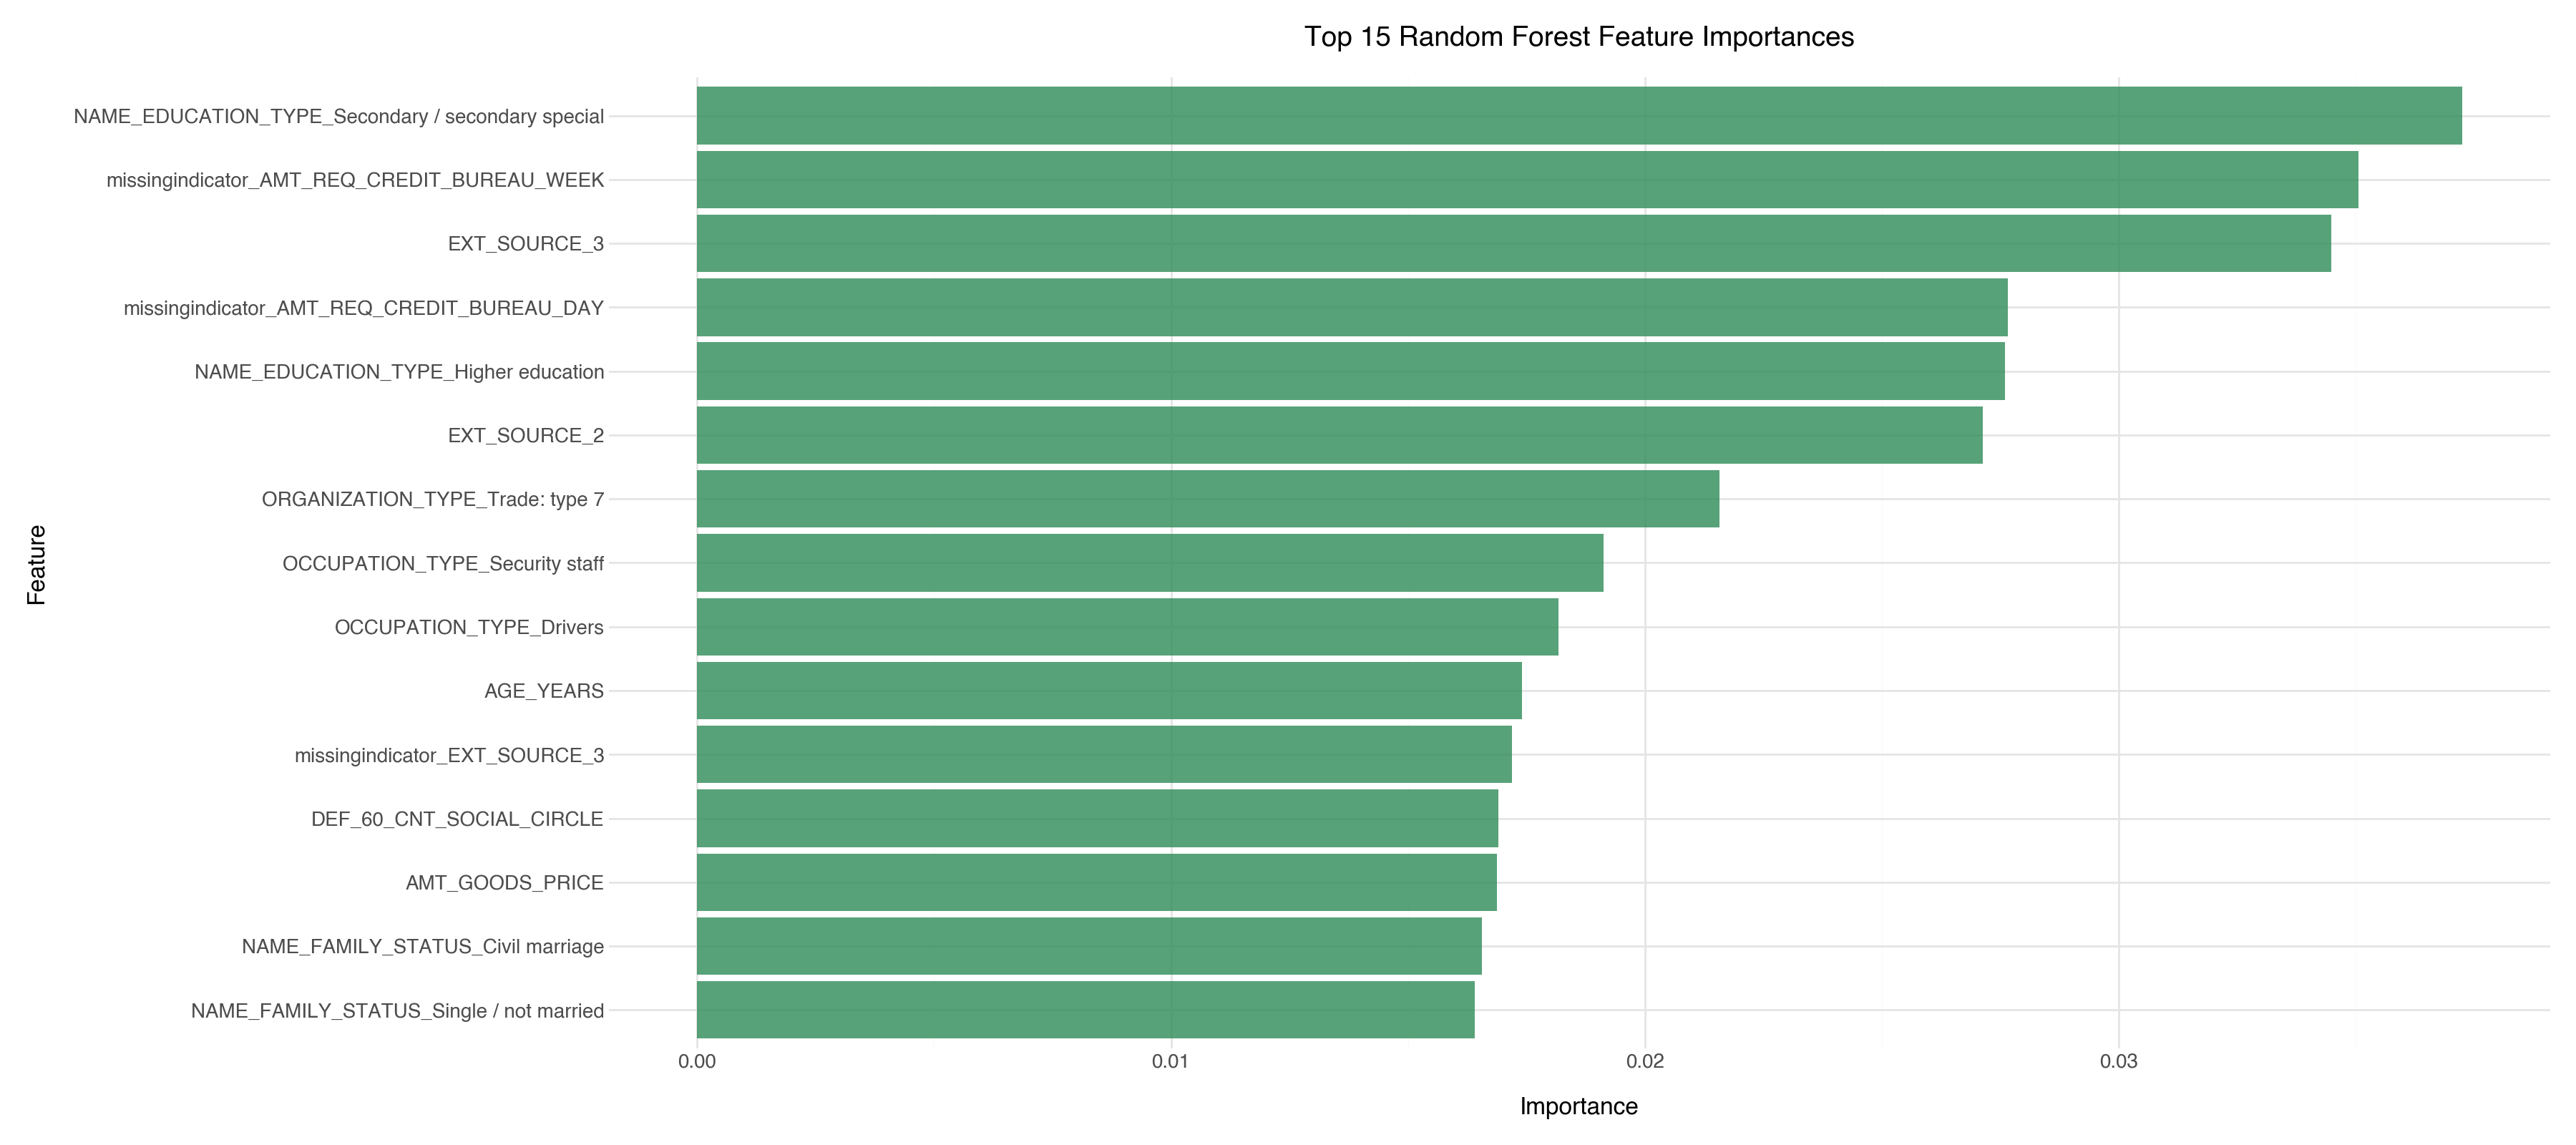

In [ ]:
from plotnine import ggplot, aes, geom_col, coord_flip, labs, theme, element_text

# Make sure feat_imp has "feature" and "importance" columns
top_feats = feat_imp.head(15).copy()

plot = (
    ggplot(top_feats, aes(x='reorder(feature, importance)', y='importance')) +
    geom_col(fill='#2E8B57', alpha=0.8) +
    coord_flip() +
    labs(
        title="Top 15 Random Forest Feature Importances",
        x="Feature",
        y="Importance"
    ) +
    theme(
        axis_text=element_text(size=10),
        axis_title=element_text(size=12),
        plot_title=element_text(size=14)
    )
)

plot

In [224]:
#determine class order of your response variable
classes = xgb_cv.best_estimator_.named_steps["model"].classes_
print("Class order:", classes)

Class order: [0 1]


In [226]:
pos_idx = list(classes).index(1)   #Put in the class you are trying to predict
proba = xgb_cv.predict_proba(Xte_enc)[:, pos_idx]

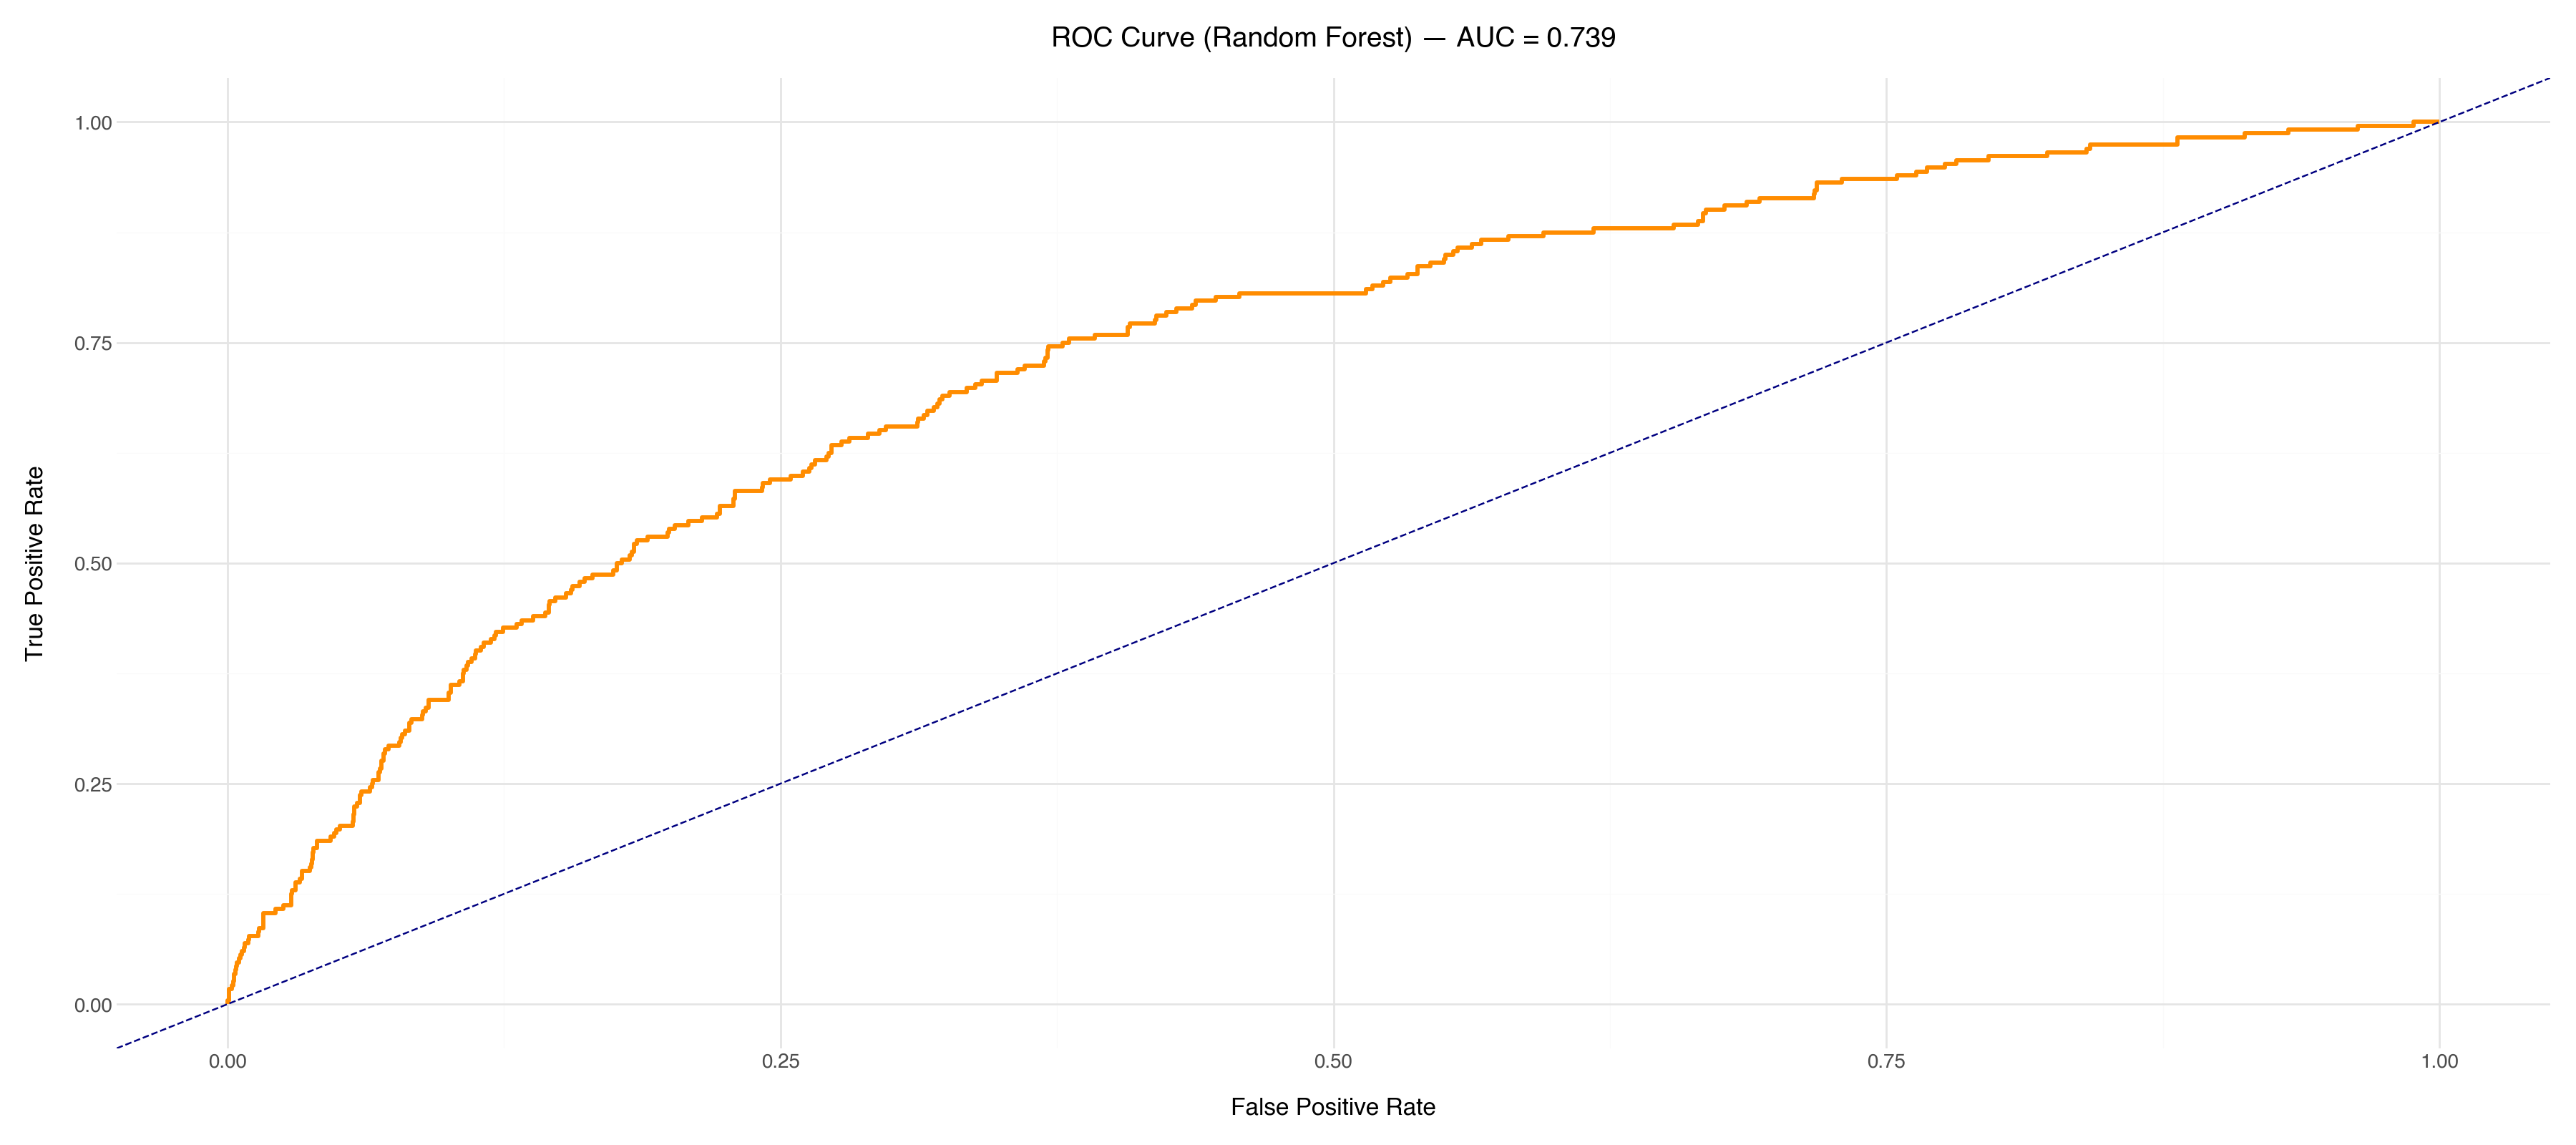

In [249]:
# fpr, tpr already computed
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

plot = (
    ggplot(roc_df, aes(x='fpr', y='tpr')) +
    geom_line(color='darkorange', size=1.2) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='navy') +
    labs(
        title=f"ROC Curve (Random Forest) — AUC = {roc_auc:.3f}",
        x="False Positive Rate",
        y="True Positive Rate"
    ) +
    theme(
        axis_text=element_text(size=10),
        axis_title=element_text(size=12),
        plot_title=element_text(size=14)
    )
)

plot

In [178]:
# 4) Train a strong baseline (XGBoost if available, else RandomForest)
if xgb is not None:
    clf = xgb.XGBClassifier(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        tree_method='hist',
        eval_metric='auc'
    )

In [179]:
clf.fit(Xtr_enc, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [180]:
# 5) Evaluate
proba_valid = clf.predict_proba(Xva_enc)[:, 1]
proba_test  = clf.predict_proba(Xte_enc)[:, 1]

print('\nVALID AUC:', roc_auc_score(y_valid, proba_valid))
print('VALID AUPRC:', average_precision_score(y_valid, proba_valid))
print('\nTEST AUC:', roc_auc_score(y_test, proba_test))
print('TEST AUPRC:', average_precision_score(y_test, proba_test))


VALID AUC: 0.702134754952219
VALID AUPRC: 0.18739403502130073

TEST AUC: 0.7319068292804465
TEST AUPRC: 0.20940296780554862


In [183]:
# Thresholded metrics (0.5 as a placeholder)
th_valid = (proba_valid >= 0.5).astype(int)
print('\nVALID classification report (thr=0.5):')
print(classification_report(y_valid, th_valid, digits=3))


VALID classification report (thr=0.5):
              precision    recall  f1-score   support

           0      0.923     0.998     0.959      2767
           1      0.375     0.013     0.025       233

    accuracy                          0.922      3000
   macro avg      0.649     0.506     0.492      3000
weighted avg      0.881     0.922     0.887      3000



In [186]:
# Make sure X_test is a DataFrame with the encoded/dummy-expanded cols and right order
# If you have arrays, wrap them:
# X_test_df = pd.DataFrame(Xte_enc, columns=feature_names, index=X_test.index)
X_test_df = X_test if hasattr(X_test, "columns") else pd.DataFrame(X_test, columns=feature_names)

# --- Build a TreeExplainer; set model_output='probability' so SHAP aligns with ROC/probabilities
try:
    explainer = shap.TreeExplainer(clf, model_output="probability")
except Exception:
    # Fallback for models not supported by TreeExplainer
    explainer = shap.Explainer(clf.predict_proba, X_test_df, algorithm="permutation")


In [237]:
# 6) SHAP explainability (sample to keep plots readable)
if xgb is not None and isinstance(clf, xgb.XGBClassifier):
    # TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(clf, feature_names=feature_names)
else:
    # Model-agnostic KernelExplainer (slow) — sample 200
    bg_idx = np.random.choice(Xtr_enc.shape[0], size=min(200, Xtr_enc.shape[0]), replace=False)
    explainer = shap.KernelExplainer(lambda d: clf.predict_proba(d)[:,1], Xtr_enc[bg_idx, :])

samp = min(2000, Xva_enc.shape[0])
idx  = np.random.choice(Xva_enc.shape[0], size=samp, replace=False)
X_shap = Xva_enc[idx, :]

shap_values = explainer(X_shap)

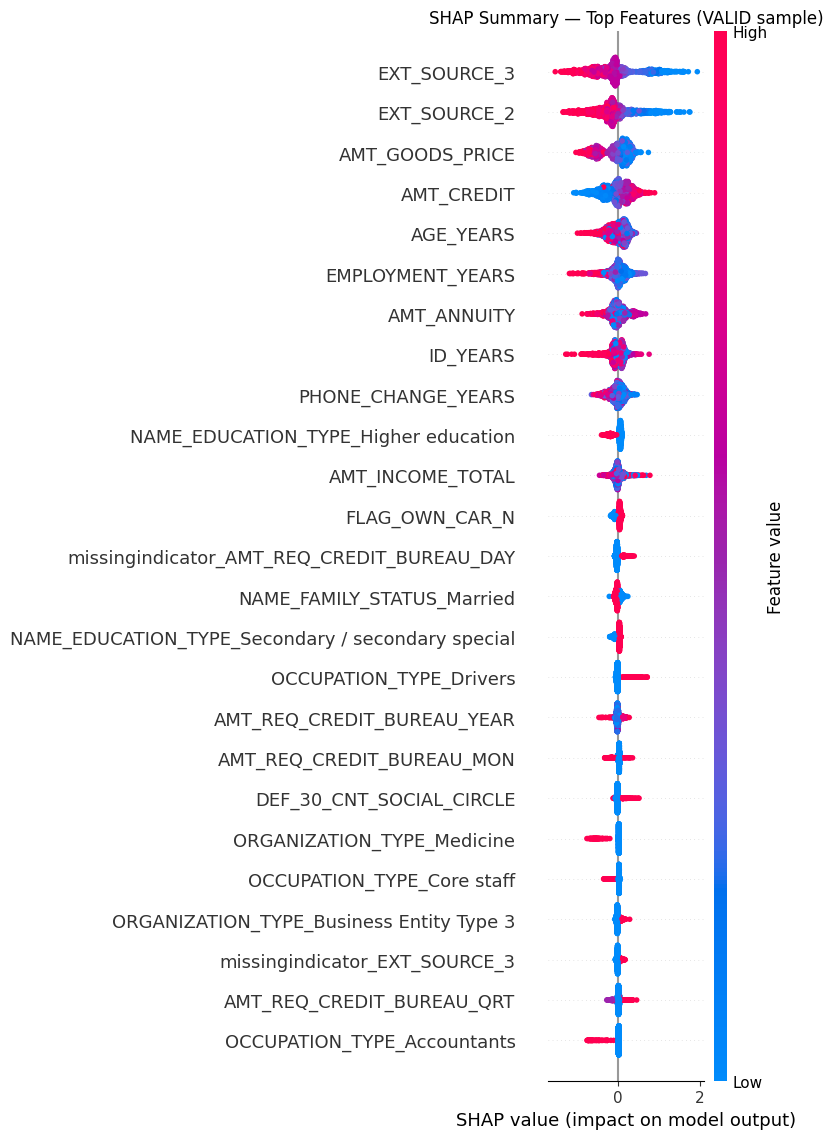

In [250]:
plt.figure(figsize=(18, 3))
shap.summary_plot(
    shap_values,
    features=X_shap,
    feature_names=feature_names,
    plot_type='dot',
    show=False,
    max_display=25
)
plt.title('SHAP Summary — Top Features (VALID sample)')
plt.tight_layout()
plt.show()


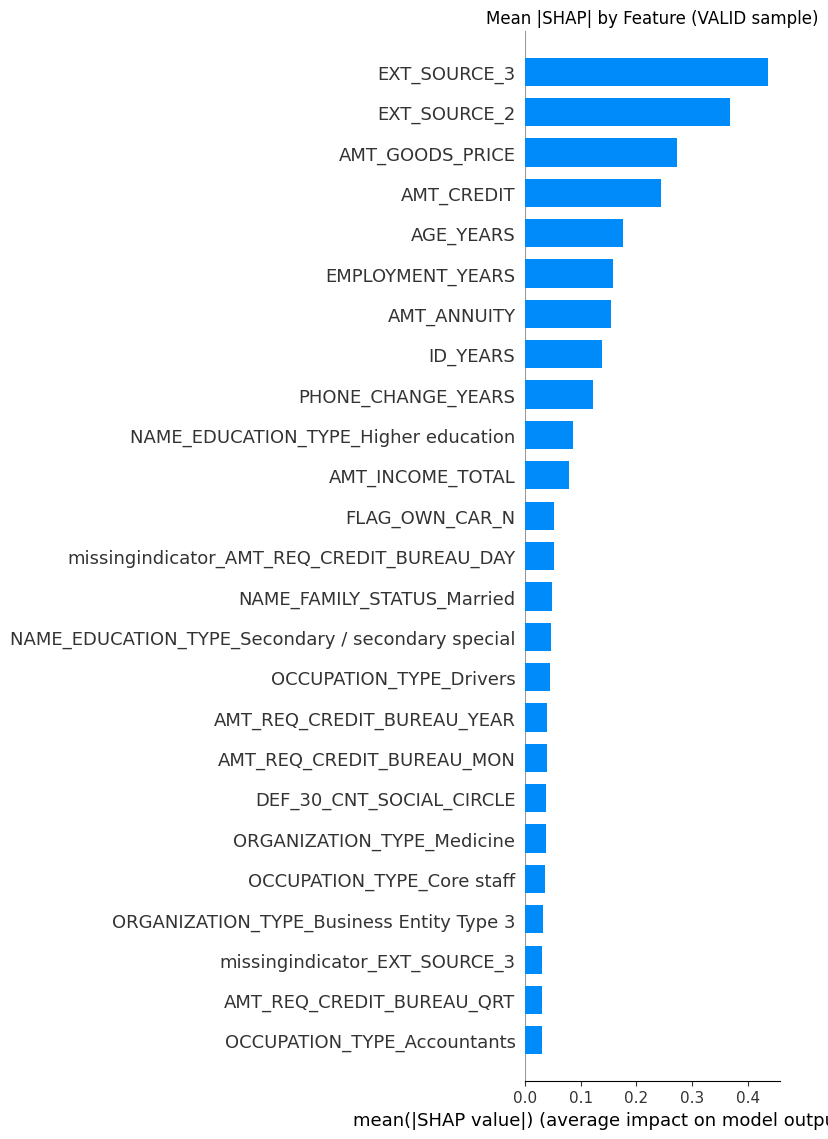

In [254]:
# --- SHAP Summary (bar) ---
plt.figure(figsize=(18, 6))
shap.summary_plot(
    shap_values,
    features=X_shap,
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=25
)
plt.title("Mean |SHAP| by Feature (VALID sample)")
plt.tight_layout()
plt.show()

In [185]:
# 7) Persist processed splits for downstream use
# Encoded matrices are numpy; wrap to DataFrame with names for convenience
Xtr_df = pd.DataFrame(Xtr_enc, columns=feature_names, index=X_train.index)
Xva_df = pd.DataFrame(Xva_enc, columns=feature_names, index=X_valid.index)
Xte_df = pd.DataFrame(Xte_enc, columns=feature_names, index=X_test.index)

Xtr_df[TARGET] = y_train.values
Xva_df[TARGET] = y_valid.values
Xte_df[TARGET] = y_test.values

Xtr_df.to_csv(os.path.join(OUT_DIR, 'train_encoded.csv'), index=False)
Xva_df.to_csv(os.path.join(OUT_DIR, 'valid_encoded.csv'), index=False)
Xte_df.to_csv(os.path.join(OUT_DIR, 'test_encoded.csv'), index=False)
print('Saved encoded splits → train/valid/test CSVs in processed_data/.')

print('\n=== PART 2 COMPLETE. ===')

Saved encoded splits → train/valid/test CSVs in processed_data/.

=== PART 2 COMPLETE. ===
